In [21]:
# !pip install mido
import string
import mido
import numpy as np
mid = mido.MidiFile('Audio/midi/suite_3/cs3-1pre.mid', clip=True)
mid.tracks

[MidiTrack([
   MetaMessage('track_name', name='untitled', time=0),
   MetaMessage('copyright', text='Copyright © 1996 by David J. Grossman', time=0),
   MetaMessage('text', text='David J. Grossman', time=0),
   MetaMessage('smpte_offset', frame_rate=25, hours=32, minutes=0, seconds=3, frames=0, sub_frames=0, time=0),
   MetaMessage('time_signature', numerator=3, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
   MetaMessage('key_signature', key='C', time=0),
   MetaMessage('set_tempo', tempo=857143, time=0),
   MetaMessage('marker', text='*', time=112320),
   MetaMessage('set_tempo', tempo=1714286, time=12960),
   MetaMessage('end_of_track', time=0)]),
 MidiTrack([
   MetaMessage('midi_port', port=0, time=0),
   MetaMessage('track_name', name='Solo Cello', time=0),
   Message('program_change', channel=0, program=42, time=0),
   Message('control_change', channel=0, control=7, value=100, time=0),
   Message('control_change', channel=0, control=10, value=64, t

In [11]:
for m in mid.tracks[0][:20]:
    print(m)

MetaMessage('track_name', name='untitled', time=0)
MetaMessage('copyright', text='Copyright © 1996 by David J. Grossman', time=0)
MetaMessage('text', text='David J. Grossman', time=0)
MetaMessage('smpte_offset', frame_rate=25, hours=32, minutes=0, seconds=3, frames=0, sub_frames=0, time=0)
MetaMessage('time_signature', numerator=3, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('set_tempo', tempo=857143, time=0)
MetaMessage('marker', text='*', time=112320)
MetaMessage('set_tempo', tempo=1714286, time=12960)
MetaMessage('end_of_track', time=0)


In [12]:
for m in mid.tracks[2][:20]:
    print(m)

MetaMessage('midi_port', port=0, time=0)
MetaMessage('track_name', name='--------------------------------------', time=0)
program_change channel=1 program=42 time=0
control_change channel=1 control=7 value=100 time=0
control_change channel=1 control=10 value=74 time=0
note_on channel=1 note=59 velocity=100 time=109440
note_on channel=1 note=59 velocity=0 time=480
note_on channel=1 note=57 velocity=100 time=2400
note_on channel=1 note=57 velocity=0 time=480
note_on channel=1 note=59 velocity=100 time=960
note_on channel=1 note=59 velocity=0 time=480
note_on channel=1 note=60 velocity=100 time=960
note_on channel=1 note=60 velocity=0 time=480
note_on channel=1 note=60 velocity=100 time=0
note_on channel=1 note=60 velocity=0 time=480
note_on channel=1 note=59 velocity=100 time=0
note_on channel=1 note=59 velocity=0 time=480
note_on channel=1 note=60 velocity=100 time=0
note_on channel=1 note=60 velocity=0 time=600
note_on channel=1 note=52 velocity=100 time=0


In [13]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [14]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

In [15]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [16]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

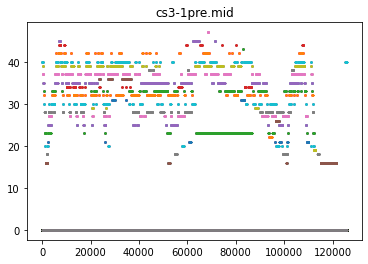

In [23]:
result_array = mid2arry(mid)
import matplotlib.pyplot as plt
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("cs3-1pre.mid")
plt.show()

In [38]:
first_note = result_array[0, :]
print(first_note)
bool_arr = np.where(first_note>0, 1, 0)
bool_arr

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [25]:
mid_new = arry2mid(result_array, 545455)
mid_new.save('mid_new.mid')